# Defining the bounds of using radioactive isotope tracers to sense past groundwater recharge under transient state conditions

This is the code accompanying the paper by Chmielarski et al. (2022) of the same name. The following code allows for the analysis of how radioactive isotope signatures in groundwater react to changes in various system paramaters (the half-life of the radioactive isotope, the Peclet number, the exchange between the mobile and immobile zones, and the ratio of water saturation in the immobile to mobile portions of the system). This exercise aims at assessing how these system parameters affect the efficacy of radioactive tracers to be used for sensing changes in groundwater recharge over time, which is here simulated by a step-change in groundwater velocity. 

Note, that this code can includes the 'DeHoog' script, which was developed by McCallum et al. (2020) using the de Hoog method (De Hoog et al., 1982) for inversing the Laplace transform, which applies a quotient-difference algorith. 

For full clarification, the analytical solution which is presented in this code can best be understood by following the supplementary documentation to the Chmielarski et al. (2022) paper, which presents a step-by-step solution. 

## Import python packages

In [69]:
import numpy as np
import scipy as sp
import pylab as plt

## de Hoog et al. (1982) implementation

In [70]:
class deHoog:
    
    def __init__(self, M = 10, T = 100., alpha = 0. , tol = 1.e-9 , gamma = -999.):
        """
        M: The number of laplace variables generated is 2N+1
        T: The frequency of the transform (as a rule of thumb 2 tmax)
        alpha : waitig on this variable
        tol: tolerance of the transform
        gamma: zero value or real component of the transformed variables
        """
        self.M = int(M/2*2) 
        if self.M <2:
            self.M = 2
        self.T =  T 
        self.alpha = alpha
        self.tol = tol
        if gamma == -999.:
            self.gamma =  self.alpha - np.log(self.tol)/(2.*self.T) 
        else:
            self.gamma = gamma
    
    def pget(self):
        dum=np.arange(0.,float(2.*self.M+1.),1.)
        self.p = self.gamma + (dum * 1j * np.pi/self.T)
         
    def invlap(self,fp,t):  
        #make and save the QD tables as the integral is time dependent 
        nt = np.size(t)
        e=np.zeros((2*self.M+1,self.M+1), dtype = complex)
        q=np.zeros((2*self.M,self.M+1), dtype = complex)
        e[:,0] = 0. + 0. * 1j  
        q[:,1] = fp[1:2*self.M+1]/fp[0:2*self.M]
        q[0,1] = fp[1]/(fp[0]/2.)
        for r in range(1,self.M+1):
            mm = 2*(self.M-r)
            e[0:mm+1,r] = q[1:mm+2,r] - q[0:mm+1,r] + e[1:mm+2,r-1]
            if r < self.M:
                rr = r+1
                mm = 2*(self.M-rr)+1
                q[0:mm+1,rr]= q[1:mm+2,rr-1]*e[1:mm+2,rr-1]/e[0:mm+1,rr-1]
        d=np.zeros(2*self.M+1,dtype=complex)
        d[0]=fp[0]/2.
        #d[1::2] = -q[0,1:]
        #d[2::2] = -e[0,1:] 
        for i in range(1,self.M+1):
            d[2*i-1] = -q[0,i]
            d[2*i] = -e[0,i]
        z=np.exp(1j * np.pi * t / self.T)
        #print(z)
        A=np.zeros((2*self.M+2,nt),dtype = complex)
        B=np.zeros((2*self.M+2,nt),dtype = complex)
        #A = np.zeros((self.M+1,nt),dtype=complex)
        A[1,:] = d[0]
        #B=np.copy(A)
        B[:2,:] = 1. + 0. * 1j
        for i in range(1,2*self.M):
            n=i+1
            #print(n)
            A[n,:] = A[n-1,:]+d[i]*A[n-2,:]*z
            B[n,:] = B[n-1,:]+d[i]*B[n-2,:]*z
        h2M = complex(.5,0.) * ( complex(1.,0.) + ( d[2*self.M-2] - d[2*self.M-1]) * z ) 
        R2M = -h2M * ( complex(1.,0.) - ( complex(1.,0.) + ( d[-1] * z ) / h2M**2 ) ** 0.5 )  
        Ap2M = A[-2,:] + R2M * A[-3,:]
        Bp2M = B[-2,:] + R2M * B[-3,:]
        dum = (Ap2M/Bp2M)
        f = (1./self.T) * np.exp ( self.gamma * t ) * dum.real
        return(f)

## Implementing the analytical solution

In [71]:
def trap(f,x):
    F = 0.
    for i in range(1,len(x),1):
        F += (f[i]+f[i-1])/2.*(x[i]-x[i-1])
    return(F)

def master(x,v,D,mu,gamma,c0):
    #x is the length of the flowlines
    #v is the velocity of the groundwater
    #D is the diffusion coefficient
    #mu covers all the first-order reaction terms, including the decay component of the equation
    #gamma covers all the zero-order or source/production terms of the equation
    #c0 is the initial concentration of the radioactive isotope in the system
    near_zero =1e-15 
    A = (v-np.sqrt(v**2+4.*D*mu))/(2*D)
    B = (v+np.sqrt(v**2+4.*D*mu))/(2*D)
    if type(gamma):
        gamma = np.ones_like(x)*gamma
    L = x[-1]
    dx = x[1]-x[0]
    c2 = A*c0*np.exp(A*L)
    if gamma[0] != 0:
        c2+= A*(np.exp(A*L)*trap(gamma*np.exp(-A*x
            )/np.sqrt(v**2+4.*D*mu),x))
        c2-= B*(np.exp(B*L)*trap(gamma*np.exp(-B*x
            )/np.sqrt(v**2+4.*D*mu),x))
    c2/=  A*np.exp(A*L) -  B*np.exp(B*L)
    c1 = c0 - c2
    c = c1*np.exp(A*x) 
    if gamma[0] != 0:
        dum1 = np.cumsum(((gamma[:-1]*np.exp(-A*x[:-1])/np.sqrt(v**2+4.*D*mu))+
                                           (gamma[1:]*np.exp(-A*x[1:])/np.sqrt(v**2+4.*D*mu)))/2.*dx)
        dum1 = np.log(gamma[:-1])-A*x[:-1]-np.log(np.sqrt(v**2+4.*D*mu))
        dum1 = np.exp(dum1)
        dum3 = np.log(gamma[1:])-A*x[1:]-np.log(np.sqrt(v**2+4.*D*mu))
        dum3 = np.exp(dum3)
        dum1 = np.cumsum((dum1+dum3)/2.*dx)
        dum2 = np.log(gamma[:-1])-B*x[:-1]-np.log(np.sqrt(v**2+4.*D*mu))
        dum2 = np.exp(dum2)
        dum3 = np.log(gamma[1:])-B*x[1:]-np.log(np.sqrt(v**2+4.*D*mu))
        dum3 = np.exp(dum3)
        dum2 = np.cumsum((dum2+dum3)/2.*dx)
        c[1:] += np.exp(A*x[1:])*dum1
        dum4 = np.exp(np.log(c2-dum2)+(B*x[1:]))
        for i in range(len(x)-1):
            term = c2-dum2[i]
            if abs(term.real)<near_zero and abs(term.imag) < near_zero:
                dum4[i] = np.complex(0.,0.)
        c[1:] += dum4
        c[0] += c2
    else:
        c+= np.exp(np.log(c2)+B*x)
    return(c)

def Soln(Pe,lam,alpha,beta,R,x,bigT):
    mu= (lam)+beta*(alpha)*(1 - (alpha/(alpha+lam)))
    
    ####Setting up the initial steady state
    #this is the steady state instant before the step change is applied 
    c_0 = master(x,1,1/(Pe),mu/R,0,1.) #this is the initial concentration in the mobile zone
    c_im0 = c_0*(alpha/(alpha+lam)) #this is the initial concentration in the immobile zone
    
    ####Generating the Laplace variables
    #T should be as close to the biggest value of bigT as possible and expressed in log terms
    #note, that T here is a function of the imported deHoog script, not dimensionless time, which is bigT
    #M is half the number of Laplace variables (smoother function = less variables, needs at least 20)
    Tmax = [0.,10.,100.]
    c_bigT= np.zeros((len(bigT),len(x))) 
    c_imbigT= np.zeros_like(c_bigT)
    for k in range(1,3):
        L=deHoog(M = 100, T = Tmax[k]) #here we call on the accompanying "deHoog" script
        L.pget() #this generates the Laplace variables
        cs = np.zeros((len(L.p),len(x)),dtype = complex)
        c_ims = np.zeros((len(L.p),len(x)),dtype = complex)
        #cs generates a number of imaginary variables, so we need to loop the function for each imaginary variable
        for i in range(len(L.p)): #for each number in the all the Laplace variables that were generated...
            mu= L.p[i] + lam+(beta*alpha)*(1 - (alpha/(alpha+lam+L.p[i]))) #adjust mu
            gamma= (beta*alpha*(c_im0/(L.p[i]+alpha+lam)))+c_0 #adjust gamma
            #the Heaviside distribution is included as the c0 = 1/L.p[i] 
            cs[i,:]= master(x,1,1/Pe,mu,gamma,1/L.p[i])
            c_ims[i,:] = cs[i,:]*(alpha/(alpha+lam))
        #Invert the laplace spec to real space 

        for j in range(len(bigT)): #for each value of bigT...
            if bigT[j] > Tmax[k-1]/10. and bigT[j] <= Tmax[k]/10.:
                for i in range(len(x)):
                    c_bigT[j,i] = L.invlap(cs[:,i],bigT[j])
                    c_imbigT[j,i] = L.invlap(c_ims[:,i],bigT[j])
        
    ####Finding the new steady state
    #this is the final equilibrium that is reached after the step change has been applied to the system
    mu= (lam)+beta*(alpha)*(1 - (alpha/(alpha+lam)))
    c_new = master(x,1,1/(Pe),mu,0,1.) #new equilibrium in the mobile zone
    c_imnew = c_new*(alpha/(alpha+lam)) #new equilibrium in the immobile zone
    
    return(c_0,c_im0,c_new,c_imnew,c_bigT,c_imbigT)


## Example of how to run the solution
See Chmielarski et al. (2022) for full description of variables.

In [72]:
Pe = 1. #dimensionless Peclet number
lam = 1. #dimensionless decay coefficient
alpha = 1. #dimensionless exchange coefficient between mobile and immobile domain
beta = 1. #ratio of mobile to immobile porosity
R = 0.1 #ratio of old to net flow rate (< 1 recharge increase, > 1 recharge decreases)
x =  np.arange(0.,1.01,0.01)

bigT = np.array([0.1, 0.2, 0.5, 1.0, 10.0]) #dimensionless time of fluching volumes to eveluate the solution at

c_0,c_im0,c_new,c_imnew,c_bigT,c_imbigT = Soln(Pe,lam,alpha,beta,R,x,bigT)


## Example of how to plot data

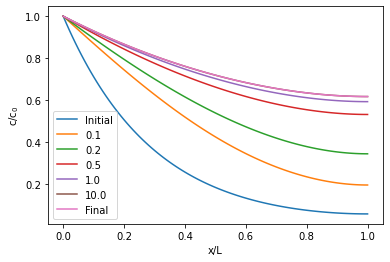

In [73]:
#plot initial solution
plt.plot(x,c_0, label = 'Initial')

#loop through bigT values
for i in range(len(bigT)):
    plt.plot(x,c_bigT[i,:], label = str(bigT[i]))

#plot final solution
plt.plot(x,c_new, label = 'Final')

#Add figure details
plt.xlabel('x/L')
plt.ylabel('c/c$_0$')
plt.legend()

Relevant references:

Chmielarski, M., Dogramaci, S., Cook, P.G., & McCallum, J.L. (2022). Defining the bounds of using radioactive isotope tracers to sense past groundwater recharge under transient state conditions. Geophysical Research Letters XXX

de Hoog, F.R., Knight, J.H., & Stokes, A.N. (1982). An improved method for numerical inversion of Laplace transforms. Society for Industrial and Applied Mathematics Journal of Science and Statistical Computing 3(3): 357-366.

McCallum, J.L., Höhne, A., Shaper, J.L., Shanafield, M., Banks, E.W., Posselt, M., Batelaan, O., & Lewandowski, J. (2020b). A numerical stream transport modelling approach including multiple conceptualizations of hyporheic exchange and spatial variability to assess contaminant removal. Water Resources Research 56, e2019WR024987. https://doi.org/10.1029/2019WR024987.